In [1]:
from __future__ import division
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
# from pandas.tools.plotting import autocorrelation_plot
# from pandas.tools.plotting import scatter_matrix
#from sklearn import  cross_val_score, metrics
#import datalab.bigquery
# import google.datalab.bigquery as bq
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from datetime import datetime
#from google.cloud import bigquery

In [2]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')

In [6]:
gdelt_query = """
SELECT Actor1Geo_CountryCode, QuadClass, SQLDATE, SUM(NumArticles) AS NumArticles
FROM [gdelt-bq:full.events]
WHERE (Actor1Geo_CountryCode==ActionGeo_CountryCode) AND (DATE(TIMESTAMP(STRING([SQLDATE]))) >= '2018-01-01')
GROUP BY Actor1Geo_CountryCode, QuadClass, SQLDATE  
ORDER BY Actor1Geo_CountryCode, QuadClass, SQLDATE """

In [7]:
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    'project-271420-fb39868c06f1.json')
project_id = 'project-271420'
client = bigquery.Client(credentials= credentials,project=project_id)


In [8]:

start = datetime.now()
query_job = client.query(gdelt_query)
print('Query done in {}s\n'.format(datetime.now()-start))

Query done in 0:00:00.462497s



In [9]:
import pandas

start = datetime.now()

sql = """
SELECT Actor1Geo_CountryCode, QuadClass, SQLDATE, SUM(NumArticles) AS NumArticles
FROM [gdelt-bq:full.events]
WHERE (Actor1Geo_CountryCode==ActionGeo_CountryCode) AND (DATE(TIMESTAMP(STRING([SQLDATE]))) >= '2018-01-01')
GROUP BY Actor1Geo_CountryCode, QuadClass, SQLDATE  
ORDER BY Actor1Geo_CountryCode, QuadClass, SQLDATE """

query_config = bigquery.QueryJobConfig(use_legacy_sql=True)

df = client.query(sql, job_config=query_config).to_dataframe()
print('Query done in {}s\n'.format(datetime.now()-start))

Query done in 0:00:22.671880s



In [10]:
df.describe()
df.to_pickle('./tf_gdelt_quad_countries_2018_now.pkl')

In [11]:
gdelt_df = pd.read_pickle('./tf_gdelt_quad_countries_2018_now.pkl')
print(gdelt_df.info())
gdelt_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624364 entries, 0 to 624363
Data columns (total 4 columns):
Actor1Geo_CountryCode    624364 non-null object
QuadClass                624364 non-null int64
SQLDATE                  624364 non-null int64
NumArticles              624364 non-null int64
dtypes: int64(3), object(1)
memory usage: 19.1+ MB
None


,QuadClass,SQLDATE,NumArticles
count,624364.00,624364.00,624364.00
mean,2.43,20186918.27,2212.44
std,1.13,6319.75,17850.20
min,1.00,20180101.00,1.00
25%,1.00,20180719.00,33.00
50%,2.00,20190203.00,138.00
75%,3.00,20190822.00,687.00
max,4.00,20200316.00,916693.00


In [12]:
def date_from_int(date_int):
  date_str = str(date_int)
  date = pd.to_datetime(date_str, format='%Y%m%d')
  return date


# Make a new index with date
gdelt_df['Date'] = gdelt_df['SQLDATE'].apply(date_from_int)
gdelt_df.index = gdelt_df['Date']
gdelt_df.drop(['SQLDATE'], axis=1, inplace=True)

In [13]:
def split_events(gdelt_df, measure_name = 'NumArticles', country = 'EG'):
  event_root_codes = gdelt_df.QuadClass.unique()
  event_series = [gdelt_df[(gdelt_df.QuadClass==event_code) & (gdelt_df.Actor1Geo_CountryCode==country)][[measure_name]]
                 for event_code in event_root_codes]
  event_by_codes = pd.concat(event_series, axis=1).sort_index()
  event_by_codes.columns = map(str, event_root_codes)
  event_by_codes = event_by_codes.fillna(method='ffill')
  event_by_codes = event_by_codes.fillna(method='bfill')
  return event_by_codes


event_by_codes = split_events(gdelt_df)

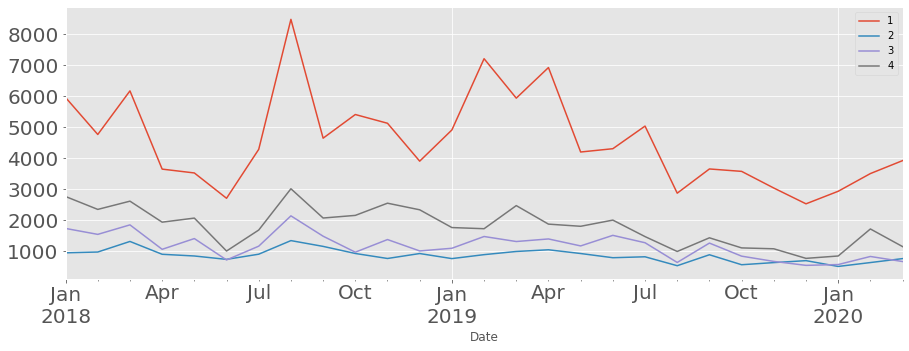

In [14]:
_ = event_by_codes.resample(rule='1M').mean().plot(figsize=(15, 5), fontsize=20)

In [15]:
def log_scale_dataframe(df):
  new_df = pd.DataFrame()
  for col in df.columns:
    new_df[col] = np.log(df[col] / df[col].shift() )
  return new_df

event_by_codes_log = log_scale_dataframe(event_by_codes)

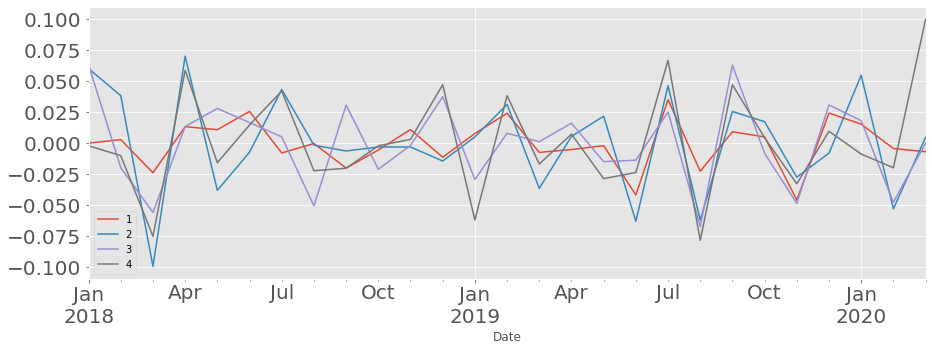

In [16]:
# Plot Growth Rate to have a look at the LOG-normalized data
_ = event_by_codes_log.resample(rule='1M').mean().plot(figsize=(15, 5), fontsize=20)

In [18]:
# Prepare X (all quads classes' Growth Rate) and y (Quad Class '4' - Material Conflict real Growth Rate)
X = event_by_codes_log.values
y = event_by_codes_log['4'].shift(periods=-1).values

# There no info from the past for the very first day.
# Let's drop out first day.
X = X[1:-1]
y = y[1:-1]

# Verify that shape of both sets are compatible
print("X shape: {}, y shape: {}".format(X.shape, y.shape)) 

# Split dataset to Train and Test partion in a ratio 80/20. 
# All model training will be done on Train part, and only evalution will be done on Test part. 
test_split = int(0.2 * len(X))
X_train = X[:test_split]
y_train = y[:test_split]
X_test = X[test_split:]
y_test = y[test_split:]

X shape: (804, 4), y shape: (804,)


In [20]:
import skflow
def rnn_input_fn(x):
  return tf.split(1, 4, x)  # 4 - number of features in X vector

# Validation monitor to do early stopping (https://en.wikipedia.org/wiki/Early_stopping) 
val_monitor = skflow.monitors.ValidationMonitor(X_test, y_test,
                                                early_stopping_rounds=200,
                                                n_classes=0,
                                                print_steps=100)

# RNN Tensorflow regression model
regressor = tf.contrib.learn.TensorFlowRNNRegressor(rnn_size=20,              # How many nodes in a layer (aka cells)
                                                    cell_type="lstm",         # Cell type (lstm has better 'memory', https://en.wikipedia.org/wiki/Long_short-term_memory)
                                                    input_op_fn=rnn_input_fn, # Input data transform function
                                                    num_layers=7,             # How many layers RNN will have (think '# of days in the past RNN will look into')
                                                    steps=1000)               # Max learning steps
# Run model training
regressor.fit(X_train, y_train, monitor=val_monitor)

# Predict Growth Rate values on Test part
y_pred = regressor.predict(X_test)

ModuleNotFoundError: No module named 'skflow'